In [1]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [2]:

def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs

In [3]:
def add_parens(perm):
    return '(' + ', '.join(list(perm)) + ')'


ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/experiments')
model_seed = 0
data_seed = 10
run_name = f'model_{model_seed}_data_{data_seed}'
#run_name = Path('s5_lr1e-5_5')

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(ckpt_dir / f'data_{data_seed}.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']


run_data = run_data.select(['permutation_left', 'permutation_right', 'permutation_target']).with_columns([
    pl.col('permutation_left').apply(add_parens),
    pl.col('permutation_right').apply(add_parens),
    pl.col('permutation_target').apply(add_parens),
])

In [4]:
list(model_run['checkpoint_epochs'])

[0,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 512,
 1024,
 2000,
 4000,
 6000,
 8000,
 10000,
 12000,
 14000,
 16000,
 18000,
 20000,
 22000,
 24000,
 25330]

In [5]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

W = model.linear.weight

lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

In [6]:
from torch.nn.functional import relu

In [7]:
logits[0, :]

tensor([42.2684, 22.5858, 20.8697, 13.1443, 17.7340, 25.7698, 18.7890, 18.2010,
        14.0315, 26.7496, 16.1528, 16.4006, 13.5034, 19.4597, 23.3572, 24.4142,
         7.7154, 14.6203,  9.7691, 22.9459,  8.4497, 10.6972, 22.6393, 13.7946,
        25.0492, 11.5506,  9.3269, 16.2584, 25.3209, 24.8456, 14.4676,  7.5808,
        14.3107, 22.7743, 14.7267,  9.3777, 16.8369, 22.8502, 16.2711, 24.9883,
        23.3261, 26.1697, 15.7574, 24.2632, 10.7304, 13.8351, 13.2025, 22.0749,
        10.6390, 27.9246, 10.1543, 27.9942, 22.7713, 14.6577,  8.2177, 21.8006,
        14.4966, 11.3855, 14.7920,  9.1383, 16.2985, 20.3745, 25.4622, 22.0036,
         9.8540,  6.7877,  8.6818, 13.3173,  7.8455,  9.3635, 22.8977,  8.7346,
        24.4994,  6.9518,  5.4726,  2.4982, 10.1470, 13.7442,  8.6674,  5.8245,
         8.8816, 17.6489, 10.0554,  2.1928,  4.5571,  8.9134, 19.0959, 25.6756,
         7.9203, 13.7044,  6.5406, 14.6540,  1.8089,  3.1535, 15.0847, 10.7472,
        14.7026, 12.9430,  8.4461, 16.65

In [14]:
(relu(linear_acts[1, :]) * model.unembed.weight[2, :])

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -8.0993e-05,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  2.2976e+00, -8.6469e-03,
        -3.7159e-02, -0.0000e+00,  0.0000e+00,  1.8571e+00,  0.0000e+00,
         0.0000e+00, -0.0000e+00,  0.0000e+00, -8.2896e-04, -5.0657e-04,
         0.0000e+00,  0.0000e+00, -0.0000e+00, -3.6471e-02,  1.0536e-02,
        -8.9601e-01, -0.0000e+00,  0.0000e+00, -2.7148e-02,  0.0000e+00,
        -0.0000e+00, -1.4298e-01,  2.4993e-03,  0.0000e+00, -7.1878e-01,
         1.0394e+00,  0.0000e+00,  2.9545e+00,  2.4874e-01,  2.9219e+00,
         0.0000e+00,  1.6113e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -9.4706e-02,  4.7317e-01, -2.9511e-01, -3.5473e-03,  8.6397e-02,
         3.4000e-02,  0.0000e+00, -0.0000e+00,  0.0000e+00, -7.2854e-02,
         0.0000e+00,  0.0000e+00, -0.0000e+00,  2.1237e-02,  2.3889e-03,
        -0.0000e+00, -2.3509e-02,  3.6906e+00,  1.1555e-01, -0.0000e+00,
        -0.0000e+00,  0.0000e+00,  1.7720e-01,  0.0

In [9]:
model.unembed.weight.shape

torch.Size([120, 128])

In [10]:
model.linear.weight.shape

torch.Size([128, 512])

In [11]:
unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)

In [12]:
from sngrok.groups import Symmetric


def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


S5 = Symmetric(5)

unembed_fb = sn_fourier_basis(unembed_ft, S5)

unembed_df = fourier_basis_to_df(unembed_fb, 5)


In [13]:
unembed_df.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",0.020403,0.145407,0.000134,0.021245,0.000126,0.002874,0.139356,0.08881,0.179401,0.003752,0.001644,0.003969,0.116082,0.191126,0.004146,0.004036,0.017147,0.193345,0.152719,0.181908,0.111357,0.000156,0.013071,-0.000913,0.149655,0.003202,0.001047,0.041162,0.001583,0.159702,0.009057,0.006911,0.001022,0.052053,0.00252,...,0.136303,0.012054,0.07108,0.004854,0.028323,0.11862,0.192314,-0.003787,0.021106,0.183694,-0.000119,0.002569,0.128573,0.046989,0.000957,0.008102,0.084709,0.003594,0.075285,0.165283,0.007072,0.142793,0.019808,0.002792,0.009205,0.017672,0.00727,0.004925,0.00082,0.065113,0.00044,0.000704,0.004517,0.131858,0.131203,0.086644,0.147294
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-0.019217,0.129731,0.019489,0.033644,-0.009,0.025441,0.156306,0.302156,0.185768,-0.034009,-0.029266,0.019599,0.269746,0.314036,-0.010394,0.020186,0.008055,0.28639,-0.854382,-0.880445,0.133839,0.01022,0.124551,-0.004085,0.243245,-0.008991,0.014124,-0.356723,-0.001812,0.326324,0.022994,0.00778,0.036501,-0.025624,0.000639,...,0.026267,0.016859,-0.738098,0.016116,-0.005331,-0.782966,0.265175,0.134373,0.00729,0.188177,-0.012858,0.03443,0.170535,0.191838,-0.008667,0.030807,0.187778,0.053221,-0.628164,0.240741,0.022342,0.321068,-0.001118,0.023673,-0.007149,0.036243,0.010869,-0.028146,0.062627,0.315325,0.008993,-0.012973,0.028763,0.16028,0.191701,0.141606,0.0714
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.221356,0.013076,0.011006,0.064341,0.016124,-0.048784,0.004214,0.002711,-0.011852,0.057292,-0.021023,0.182409,0.012934,0.003077,-0.044637,0.061009,-0.243965,-0.005088,0.035554,-0.012423,0.004282,-0.018067,-0.028282,0.041125,-0.005251,0.006829,-0.040104,0.014057,0.084126,-0.012719,0.308576,-0.015392,0.019034,-0.02349,-0.047622,...,-0.006452,0.007165,0.083155,-0.0081,-0.192838,0.042562,0.000116,0.016447,0.096221,-0.006146,-0.011849,-0.024707,-0.001779,0.00143,0.01318,0.068039,-0.024559,-0.001999,0.014991,-0.001125,0.018308,-0.022161,-0.039526,0.024039,0.011848,-0.420871,0.010918,0.272958,0.035559,0.00807,0.015214,0.168412,-0.047906,-0.004854,-0.024317,0.021353,0.007978
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.017921,0.016008,-0.05349,0.053568,-0.036332,0.064505,-0.017817,0.002497,-0.000906,0.005509,0.030683,-0.029387,0.0291,-0.004994,0.004465,-0.017668,0.076722,-0.006491,-0.003203,0.002085,0.003067,0.012146,0.005529,-0.003208,-0.028575,0.036397,-0.020088,0.006804,0.01296,-0.00066,-0.009779,0.056459,0.015323,-0.007191,0.021084,...,-0.017644,-0.017883,-0.006377,-0.005417,0.004881,-0.010561,0.004419,-0.043784,0.015447,-0.00236,0.035715,-0.033969,-0.007508,0.007786,0.017351,0.01402,0.008849,0.004664,-0.04699,-0.015953,-0.046863,0.01912,0.053661,0.018994,0.048603,0.016053,-0.048054,0.011563,0.008276,0.007082,0.009556,-0.007175,0.006219,-0.025527,-0.013859,-0.015705,-0.018795
"""(0, 1, 2, 3, 4...","""(3, 2)""",-0.02635,0.009361,0.00327,-0.016432,-0.026808,-0.019551,-0.004399,0.00155,0.005461,-0.216549,0.302444,-0.029353,-0.011511,-0.022293,0.209444,0.00404,0.000512,-0.006116,0.005075,0.019615,0.001844,0.015321,0.020356,-0.003704,0.011867,0.002881,-0.052696,-0.013909,-0.013185,0.013995,-0.038754,-0.03008,0.047411,0.146877,0.020575,...,-0.010376,0.000138,-0.000229,0.003637,

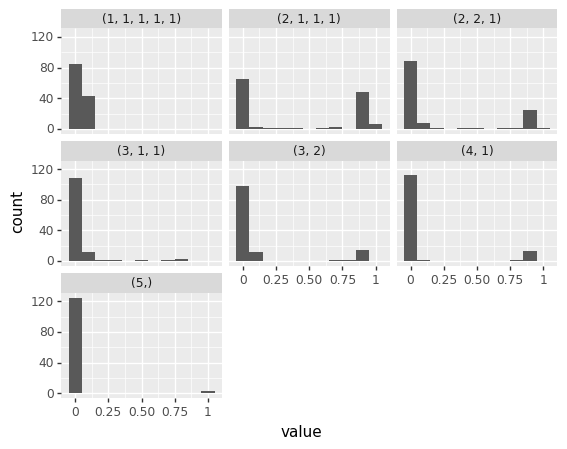

<ggplot: (388731814)>

In [14]:
df = (
    unembed_power_df
    .melt(id_vars='irrep')
)
ggplot(df, aes(x ='value')) + geom_histogram(binwidth=0.1) + facet_wrap('~irrep')

In [15]:
df.filter((pl.col('irrep') == "(2, 1, 1, 1)")).sort('value').tail(20)

irrep,variable,value
str,str,f32
"""(2, 1, 1, 1)""","""dim72""",0.913305
"""(2, 1, 1, 1)""","""dim20""",0.913879
"""(2, 1, 1, 1)""","""dim39""",0.915705
"""(2, 1, 1, 1)""","""dim37""",0.915824
"""(2, 1, 1, 1)""","""dim48""",0.916519
"""(2, 1, 1, 1)""","""dim52""",0.925472
"""(2, 1, 1, 1)""","""dim7""",0.925668
"""(2, 1, 1, 1)""","""dim126""",0.930996
"""(2, 1, 1, 1)""","""dim68""",0.933755


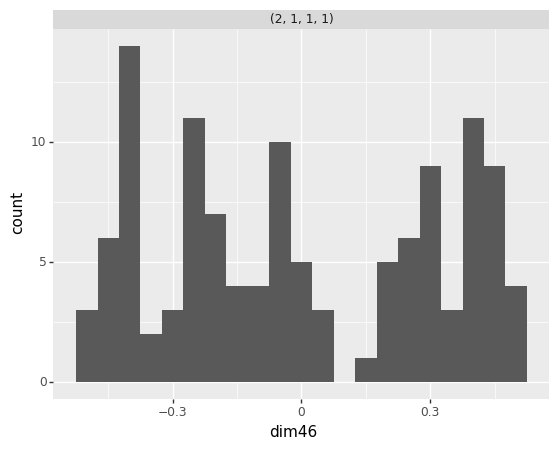

<ggplot: (697341823)>

In [16]:
col = 'dim46'
ggplot(
    unembed_df.filter(pl.col('irrep') == "(2, 1, 1, 1)").select(['permutation', 'irrep', col]),
    aes(x = col)
) + geom_histogram(binwidth=0.05) + facet_wrap('~irrep')

In [17]:
def get_index_of(col_name, element):
    return (
        pl.col(col_name)
        .arr.eval((pl.element() == element).cast(pl.UInt32))
        .arr.arg_max().cast(pl.Utf8)
    )

unembed_df = (
    unembed_df
    .with_columns([
            pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
        ])
        .with_columns([
            pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
            pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
            pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
            pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
            pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
            get_index_of('target_vals', '0').alias('index_of_0'),
            get_index_of('target_vals', '1').alias('index_of_1'),
            get_index_of('target_vals', '2').alias('index_of_2'),
            get_index_of('target_vals', '3').alias('index_of_3'),
            get_index_of('target_vals', '4').alias('index_of_4'),
            #pl.col(col).alias('activation')
        ])
)

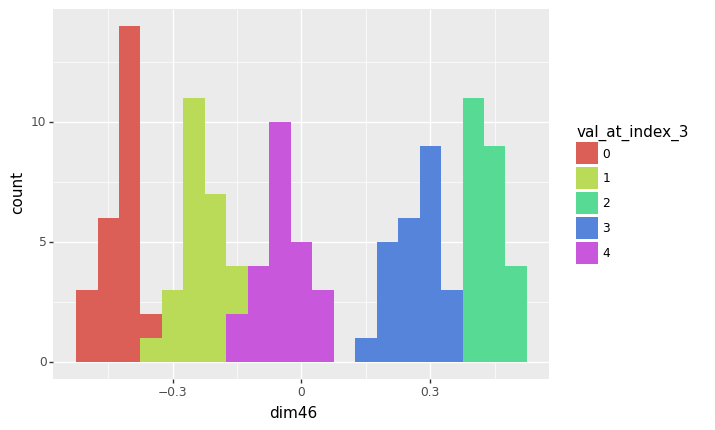

<ggplot: (697579557)>

In [18]:
col = 'dim46'
va = 3

coset_col = f'val_at_index_{va}'

ggplot(
    unembed_df.filter(pl.col('irrep') == "(2, 1, 1, 1)").select(['permutation', 'irrep', coset_col, col]),
    aes(x = col, fill=coset_col)
) + geom_histogram(binwidth=0.05)

In [28]:

linear_preacts_df = pl.concat(
    [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])],
    how='horizontal'
)


linear_preacts_df.head()

permutation_left,permutation_right,permutation_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",-2.109075,-8.005809,-0.177685,-0.384412,-0.110391,1.18496,-6.929645,3.96369,6.376388,-0.34583,0.983768,-0.241233,-4.444966,3.844228,-0.996589,-1.80641,0.14442,-3.580109,0.000809,0.000311,2.506026,-0.131278,-3.366219,0.271759,7.50627,-0.419128,-0.333985,-0.598786,0.409216,-6.030128,-0.937278,0.21716,0.202158,-2.077939,...,-3.256288,1.108241,-0.202104,-0.259418,2.489586,0.000631,-3.226288,1.266912,1.324032,3.690197,0.307455,-0.731126,8.711966,2.950668,-0.5346,-1.088307,-0.909726,1.363634,-0.001951,-12.187197,1.332865,2.401249,1.711538,0.423786,0.951222,-0.665957,0.073028,1.678034,0.925296,6.271162,0.115387,-1.198172,-0.761675,6.910126,-4.948,2.883769,3.342357
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",-1.751873,-8.010602,-0.099761,-0.369474,0.002223,-0.240934,-7.14139,-2.628881,6.356492,0.126484,0.194974,-0.473774,-0.232284,3.84463,-0.252629,-0.004426,-0.21986,-7.192867,0.001182,0.000714,-6.774814,-0.122095,-3.240023,0.325669,0.027342,1.971404,-0.000073,-4.311964,0.150584,-6.03002,-0.643011,0.640402,0.029744,-1.041477,...,7.089485,0.400492,0.007554,-1.752988,1.604976,2.399207,9.728498,1.059462,1.692075,0.005439,0.029489,1.001184,10.806063,-2.695063,-0.008148,-1.278555,4.468103,0.309646,-8.396626,-0.010906,0.53768,2.195478,1.680309,-0.164652,0.906262,-0.355185,-0.125357,1.827979,-0.92728,0.028841,0.158648,-1.859881,0.383847,-2.729646,-4.921893,2.874353,3.343708
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",-2.454712,-7.817763,-0.110293,0.864467,-0.034211,0.800307,-7.125122,-5.742765,6.357032,-0.307653,0.073937,-0.680667,6.242032,3.844229,-0.679958,-1.320288,0.036736,5.631201,0.000346,0.009102,0.695261,0.510097,2.736037,0.407861,-3.473042,-0.302967,-0.276482,-0.615692,0.027655,-6.031089,0.119159,0.149865,0.17242,-1.826709,...,8.092784,1.603198,0.003687,-0.257277,2.264887,-8.262766,0.000944,1.396444,-0.267409,12.918144,0.288745,-0.485349,-0.000293,-0.53333,0.298845,-1.424189,-5.22471,-0.033561,-2.736486,-8.145681,1.006899,2.267119,0.60668,-0.055997,0.553205,-1.676225,-0.243313,2.207087,0.768462,7.043735,0.033109,-1.74146,0.60786,0.001566,-4.794738,2.793016,3.558759
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",-2.031527,0.006514,0.009166,1.660644,-0.129624,0.679864,-8.210882,-2.629275,6.356444,0.53813,0.951696,-1.032113,-0.256829,3.84401,-0.064401,-0.927494,1.970139,-11.033205,8.057287,0.000878,0.726133,-0.296427,-3.12401,0.565958,-3.405221,0.170275,-0.027271,-0.639087,0.041912,-6.031313,0.109542,0.578702,0.080908,-0.000105,...,7.092199,1.611514,0.000302,-0.124213,1.945864,-8.254316,9.73686,1.438115,-0.652192,-3.801057,0.125586,-0.330782,0.000528,0.801919,0.447729,-0.371605,-5.225408,0.16414,-8.396548,-0.008091,0.003882,0.00048,-0.291965,0.221587,-0.713702,-2.444324,0.697204,1.98887,0.329504,7.124047,0.161558,-1.210453,0.536465,0.047985,2.668799,-2.619722,11.453037
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",-2.332162,2.110672,-0.137973,1.602635,-0.121136,0.70563,1.604742,3.934901,6.497367,-0.183692,0.569683,-1.015378,-4.445276,3.843619,-0.860763,-1.145688,1.333184,-11.032122,11.816202,0.001969,-6

In [52]:
#model.unembed.weight @ relu(linear_acts.T)

(model.unembed.weight[0, :] @ relu(linear_acts.T[:, 1]))

tensor(22.5737, grad_fn=<DotBackward0>)

In [44]:
(linear_acts.T[:, 1])

torch.Size([128])

In [33]:
from torch.nn.functional import relu

lacts = (model.unembed.weight @ relu(linear_acts.T)).T

linear_acts_df = pl.concat(
    [run_data, pl.DataFrame(lacts.detach().numpy(), schema=[str(p) for p in Permutation.full_group(5)])],
    how='horizontal'
)


linear_acts_df.head()

permutation_left,permutation_right,permutation_target,"(0, 1, 2, 3, 4)","(0, 1, 3, 4, 2)","(0, 1, 4, 2, 3)","(0, 2, 1, 4, 3)","(0, 2, 3, 1, 4)","(0, 2, 4, 3, 1)","(0, 3, 1, 2, 4)","(0, 3, 2, 4, 1)","(0, 3, 4, 1, 2)","(0, 4, 1, 3, 2)","(0, 4, 2, 1, 3)","(0, 4, 3, 2, 1)","(1, 0, 2, 4, 3)","(1, 0, 3, 2, 4)","(1, 0, 4, 3, 2)","(1, 2, 0, 3, 4)","(1, 2, 3, 4, 0)","(1, 2, 4, 0, 3)","(1, 3, 0, 4, 2)","(1, 3, 2, 0, 4)","(1, 3, 4, 2, 0)","(1, 4, 0, 2, 3)","(1, 4, 2, 3, 0)","(1, 4, 3, 0, 2)","(2, 0, 1, 3, 4)","(2, 0, 3, 4, 1)","(2, 0, 4, 1, 3)","(2, 1, 0, 4, 3)","(2, 1, 3, 0, 4)","(2, 1, 4, 3, 0)","(2, 3, 0, 1, 4)","(2, 3, 1, 4, 0)","(2, 3, 4, 0, 1)","(2, 4, 0, 3, 1)",...,"(1, 4, 3, 2, 0)","(2, 0, 1, 4, 3)","(2, 0, 3, 1, 4)","(2, 0, 4, 3, 1)","(2, 1, 0, 3, 4)","(2, 1, 3, 4, 0)","(2, 1, 4, 0, 3)","(2, 3, 0, 4, 1)","(2, 3, 1, 0, 4)","(2, 3, 4, 1, 0)","(2, 4, 0, 1, 3)","(2, 4, 1, 3, 0)","(2, 4, 3, 0, 1)","(3, 0, 1, 2, 4)","(3, 0, 2, 4, 1)","(3, 0, 4, 1, 2)","(3, 1, 0, 4, 2)","(3, 1, 2, 0, 4)","(3, 1, 4, 2, 0)","(3, 2, 0, 1, 4)","(3, 2, 1, 4, 0)","(3, 2, 4, 0, 1)","(3, 4, 0, 2, 1)","(3, 4, 1, 0, 2)","(3, 4, 2, 1, 0)","(4, 0, 1, 3, 2)","(4, 0, 2, 1, 3)","(4, 0, 3, 2, 1)","(4, 1, 0, 2, 3)","(4, 1, 2, 3, 0)","(4, 1, 3, 0, 2)","(4, 2, 0, 3, 1)","(4, 2, 1, 0, 3)","(4, 2, 3, 1, 0)","(4, 3, 0, 1, 2)","(4, 3, 1, 2, 0)","(4, 3, 2, 0, 1)"
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",42.187904,22.560081,20.817009,13.053423,17.648245,25.705597,18.697304,18.131861,14.004471,26.736982,16.102699,16.343168,13.509833,19.397427,23.385761,24.353634,7.642517,14.531037,9.741326,22.943668,8.40556,10.682968,22.622873,13.828857,24.987125,11.54165,9.289238,16.18034,25.245926,24.812578,14.3866,7.544737,14.280506,22.766844,...,2.259358,4.622667,8.951034,19.140211,25.708776,7.945397,13.765713,6.615078,14.657884,1.906638,3.203218,15.182196,10.820865,14.714865,13.00205,8.480093,16.726046,25.790997,13.34068,13.269632,6.23887,13.348177,9.924283,12.005435,8.711104,16.927811,5.321281,5.952779,9.852218,22.16058,15.355115,15.271623,7.600321,0.836791,3.087434,0.408452,10.190084
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",22.573713,43.485981,17.995939,25.972027,18.271803,19.268106,11.31386,25.763948,20.028706,23.000362,12.498993,21.12915,21.866438,16.449808,20.477373,12.535561,26.469877,15.600773,26.197607,12.810754,9.343639,9.338114,11.979044,23.936283,12.764504,28.941818,8.768809,26.320883,21.693592,17.744825,7.710113,19.417896,16.259169,14.229292,...,7.883502,13.532985,4.725316,9.68598,8.89513,22.715067,9.650293,14.870814,6.276926,0.624974,1.629301,4.68425,12.317704,3.06458,18.297138,8.254107,24.276449,11.418734,8.811652,3.085019,14.173697,10.495645,4.063542,11.209373,2.40317,17.30868,8.845571,17.188532,13.204558,18.036171,25.832056,15.501544,14.477576,14.523404,11.739897,8.117872,13.818402
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",26.933573,22.259935,45.388851,23.859522,11.557053,21.591322,29.752567,22.062113,21.222244,16.614609,21.98871,24.677807,22.128229,22.987005,18.854248,11.647691,8.358506,25.213507,16.512774,19.422028,29.753061,29.267092,11.418593,11.434944,17.473557,18.801701,26.656439,30.410578,21.08605,25.156734,16.700294,18.767513,27.315069,17.031305,...,12.38736,19.309414,6.124275,19.950075,15.855684,13.551965,29.080147,16.538361,16.186506,12.807953,15.269966,7.95048,11.745083,17.225286,10.847396,8.467035,16.778759,15.160921,25.516172,6.483043,5.567599,11.454766,19.141562,7.94883,3.269692,7.292684,12.512294,16.045807,29.609486,12.919644,11.890761,8.047649,14.739813,-0.397564,6.033457,15.39241,12.460461
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",13.113218,25.264904,18.026575,44.137

In [20]:
linear_acts_df = (
    linear_acts_df.with_columns([
            pl.col('permutation_target').str.extract_all('([0-4])').alias('target_vals'),
        ])
        .with_columns([
            pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
            pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
            pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
            pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
            pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
            get_index_of('target_vals', '0').alias('index_of_0'),
            get_index_of('target_vals', '1').alias('index_of_1'),
            get_index_of('target_vals', '2').alias('index_of_2'),
            get_index_of('target_vals', '3').alias('index_of_3'),
            get_index_of('target_vals', '4').alias('index_of_4'),
            #pl.col(col).alias('activation')
        ])
)


In [21]:
linear_acts_df.head()

permutation_left,permutation_right,permutation_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,...,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127,target_vals,val_at_index_0,val_at_index_1,val_at_index_2,val_at_index_3,val_at_index_4,index_of_0,index_of_1,index_of_2,index_of_3,index_of_4
str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,list[str],str,str,str,str,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...",-2.109075,-8.005809,-0.177685,-0.384412,-0.110391,1.18496,-6.929645,3.96369,6.376388,-0.34583,0.983768,-0.241233,-4.444966,3.844228,-0.996589,-1.80641,0.14442,-3.580109,0.000809,0.000311,2.506026,-0.131278,-3.366219,0.271759,7.50627,-0.419128,-0.333985,-0.598786,0.409216,-6.030128,-0.937278,0.21716,0.202158,-2.077939,...,-0.731126,8.711966,2.950668,-0.5346,-1.088307,-0.909726,1.363634,-0.001951,-12.187197,1.332865,2.401249,1.711538,0.423786,0.951222,-0.665957,0.073028,1.678034,0.925296,6.271162,0.115387,-1.198172,-0.761675,6.910126,-4.948,2.883769,3.342357,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(0, 1, 3, 4, 2...",-1.751873,-8.010602,-0.099761,-0.369474,0.002223,-0.240934,-7.14139,-2.628881,6.356492,0.126484,0.194974,-0.473774,-0.232284,3.84463,-0.252629,-0.004426,-0.21986,-7.192867,0.001182,0.000714,-6.774814,-0.122095,-3.240023,0.325669,0.027342,1.971404,-0.000073,-4.311964,0.150584,-6.03002,-0.643011,0.640402,0.029744,-1.041477,...,1.001184,10.806063,-2.695063,-0.008148,-1.278555,4.468103,0.309646,-8.396626,-0.010906,0.53768,2.195478,1.680309,-0.164652,0.906262,-0.355185,-0.125357,1.827979,-0.92728,0.028841,0.158648,-1.859881,0.383847,-2.729646,-4.921893,2.874353,3.343708,"[""0"", ""1"", ... ""2""]","""0""","""1""","""3""","""4""","""2""","""0""","""1""","""4""","""2""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(0, 1, 4, 2, 3...",-2.454712,-7.817763,-0.110293,0.864467,-0.034211,0.800307,-7.125122,-5.742765,6.357032,-0.307653,0.073937,-0.680667,6.242032,3.844229,-0.679958,-1.320288,0.036736,5.631201,0.000346,0.009102,0.695261,0.510097,2.736037,0.407861,-3.473042,-0.302967,-0.276482,-0.615692,0.027655,-6.031089,0.119159,0.149865,0.17242,-1.826709,...,-0.485349,-0.000293,-0.53333,0.298845,-1.424189,-5.22471,-0.033561,-2.736486,-8.145681,1.006899,2.267119,0.60668,-0.055997,0.553205,-1.676225,-0.243313,2.207087,0.768462,7.043735,0.033109,-1.74146,0.60786,0.001566,-4.794738,2.793016,3.558759,"[""0"", ""1"", ... ""3""]","""0""","""1""","""4""","""2""","""3""","""0""","""1""","""3""","""4""","""2"""
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(0, 2, 1, 4, 3...",-2.031527,0.006514,0.009166,1.660644,-0.129624,0.679864,-8.210882,-2.629275,6.356444,0.53813,0.951696,-1.032113,-0.256829,3.84401,-0.064401,-0.927494,1.970139,-11.033205,8.057287,0.000878,0.726133,-0.296427,-3.12401,0.565958,-3.405221,0.170275,-0.027271,-0.639087,0.041912,-6.031313,0.109542,0.578702,0.080908,-0.000105,...,-0.330782,0.000528,0.801919,0.447729,-0.371605,-5.225408,0.16414,-8.396548,-0.008091,0.003882,0.00048,-0.291965,0.221587,-0.713702,-2.444324,0.697204,1.98887,0.329504,7.124047,0.161558,-1.210453,0.536465,0.047985,2.668799,-2.619722,11.453037,"[""0"", ""2"", ... ""3""]","""0""","""2""","""1""","""4""","""3""","""0""","""2""","""1""","""4""","""3"""
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(0, 2, 3, 1, 4...",-2.332162,2.110672,-0.137973,1.602635,-0.121136,0.70563,1.604742,3.934901,6.497367,-0.18

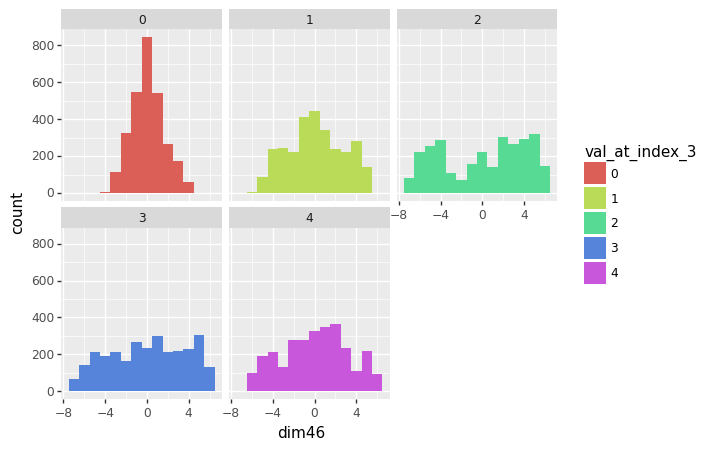

<ggplot: (682977686)>

In [22]:
col = 'dim46'
va = 3
coset_col = f'val_at_index_{va}'
ggplot(
    linear_acts_df.select(['permutation_target', coset_col, col]),
    aes(x = col, fill=coset_col)
) + geom_histogram(binwidth=1) + facet_wrap(f'~{coset_col}')

In [31]:
linear_acts_df['val_at_index_4'].str.parse_int(10).apply(lambda x: {f'val_at_4_{i}': (0 if i != x else 1)for i in range(5)}).struct.unnest()

val_at_4_0,val_at_4_1,val_at_4_2,val_at_4_3,val_at_4_4
i64,i64,i64,i64,i64
0,0,0,0,1
0,0,1,0,0
0,0,0,1,0
0,0,0,1,0
0,0,0,0,1
0,1,0,0,0
0,0,0,0,1
0,1,0,0,0
0,0,1,0,0


In [32]:
def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


W = model.linear.weight

llin_ft = slow_sn_ft_1d(model.lembed.weight @ W[:, :256].T, 5)
rlin_ft = slow_sn_ft_1d(model.rembed.weight @ W[:, 256:].T, 5)
llin_fb = sn_fourier_basis(llin_ft, S5)
llin_df = fourier_basis_to_df(llin_fb, 5)

rlin_fb = sn_fourier_basis(rlin_ft, S5)
rlin_df = fourier_basis_to_df(rlin_fb, 5)


In [33]:
llin_df = (
    llin_df
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])

)

rlin_df = (
    rlin_df
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])

)

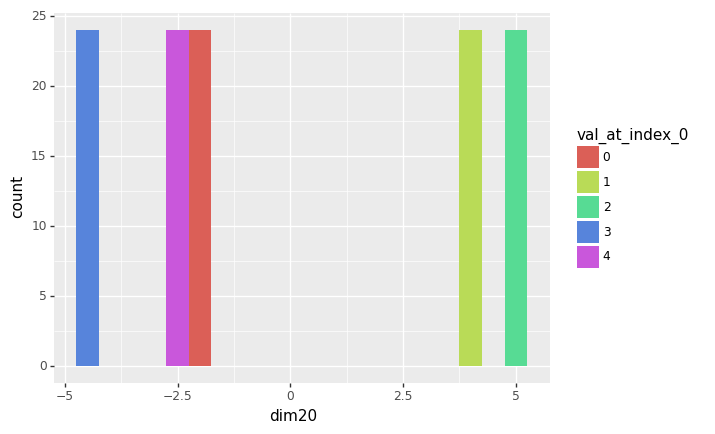

<ggplot: (710144490)>

In [154]:
col = 'dim20'
va = 0

coset_col = f'val_at_index_{va}'

ggplot(
    llin_df.filter(pl.col('irrep') == "(2, 1, 1, 1)").select(['permutation', 'irrep', coset_col, col]),
    aes(x = col, fill=coset_col)
) + geom_histogram(binwidth=0.5)

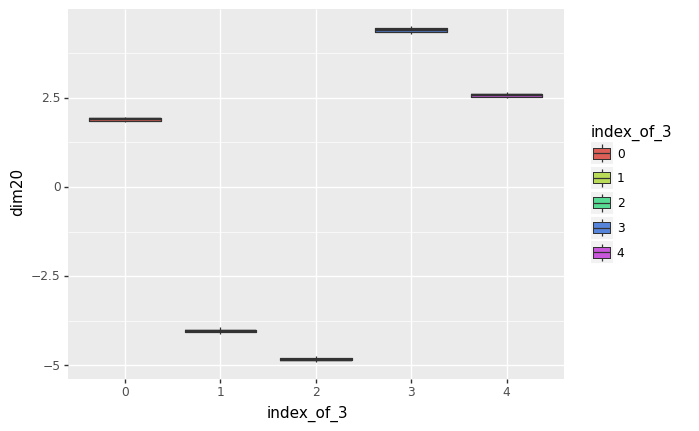

<ggplot: (705049811)>

In [56]:
col = 'dim20'
va = 3


coset_col = f'index_of_{va}'

ggplot(
    rlin_df.filter(pl.col('irrep') == "(2, 1, 1, 1)").select(['permutation', 'irrep', coset_col, col]),
    aes(y = col, x=coset_col, fill=coset_col)
) + geom_boxplot()

In [79]:
def perm_to_one_hot(data, column):
    return (
        data[column]
        .str.parse_int(10)
        .apply(lambda x: {(column + '-' + str(i)): (0 if i != x else 1)for i in range(5)})
        .struct.unnest()
    )



right2111 = rlin_df.filter(pl.col('irrep') == '(2, 1, 1, 1)')


index_data = pl.concat([perm_to_one_hot(right2111, f'index_of_{i}') for i in range(5)], how='horizontal')

In [92]:
X = index_data.to_numpy()
y = right2111['dim46'].to_numpy()

m = linear_model.Lasso(0.1).fit(X, y)

In [93]:
m.coef_

array([-0.        ,  1.2531894 ,  1.99215408, -0.        , -0.72757469,
       -0.        ,  0.        ,  0.32696506, -0.        , -0.29195337,
        0.        , -1.05763684, -1.60542744,  0.        ,  0.21116462,
        0.        , -0.25885216, -0.69816661,  0.        ,  0.02645831,
        0.        ,  0.        ,  0.        , -0.        , -0.        ])

In [94]:
m.score(X, y)

0.8673776061337747

In [105]:
S5 = Symmetric(5)

rembed_power_df, rembed_ft = calc_power_contributions(model.rembed.weight, 5)

rembed_fb = sn_fourier_basis(rembed_ft, S5)

rembed_df = fourier_basis_to_df(rembed_fb, 5)

In [141]:

lembed_power_df, lembed_ft = calc_power_contributions(model.rembed.weight, 5)

lembed_fb = sn_fourier_basis(lembed_ft, S5)

lembed_df = fourier_basis_to_df(lembed_fb, 5)

In [142]:
lembed_df = (
    lembed_df
    .melt(id_vars=['permutation', 'irrep'])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'),
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

In [169]:
lembed_power_df.melt(id_vars='irrep').filter(pl.col('irrep') == "(2, 1, 1, 1)").sort('value').head(20)

irrep,variable,value
str,str,f32
"""(2, 1, 1, 1)""","""dim29""",0.558929
"""(2, 1, 1, 1)""","""dim201""",0.64241
"""(2, 1, 1, 1)""","""dim14""",0.676975
"""(2, 1, 1, 1)""","""dim34""",0.692581
"""(2, 1, 1, 1)""","""dim246""",0.693932
"""(2, 1, 1, 1)""","""dim242""",0.703302
"""(2, 1, 1, 1)""","""dim206""",0.704457
"""(2, 1, 1, 1)""","""dim36""",0.709483
"""(2, 1, 1, 1)""","""dim142""",0.709992


In [167]:
from plotnine import qplot

model.linear.weight[20, :256].abs().argsort()

tensor([ 30,  16, 253, 112,  40,  42, 251, 204, 209,  26, 237, 226, 186, 147,
         57,  70,  13, 234, 240, 123, 114,  29,  54, 101,   0, 189, 165, 192,
        100,   1, 182,  97, 245,   7,  92, 232, 229,  43,  44, 227, 105,  94,
        120,  41,  93,  63, 196,  12, 187,  46,   9,  77, 142, 190, 241,  71,
        158,  76, 233, 213,  89, 154, 223,  39, 143, 166,  85, 181, 242, 205,
        121, 171, 108, 202,   5, 177,  48, 215,  52, 129, 145, 167, 103, 146,
        139,  34, 159,  90,  24, 243,  87, 151, 163,  83, 230,  15,  78,  21,
        104, 138, 220, 156, 239, 214, 221,  61,  37,  84,  60, 238,  79, 212,
         36, 170, 173,  53, 135, 168,  72, 113, 252, 174, 124,  25,   8,  35,
        194, 126, 140, 110,  32, 116,   2, 172,  17, 199,  22, 136, 254,  74,
        198, 144,  55, 178, 111,  67, 148,  65, 219, 191,  33, 131, 236, 188,
         47, 225, 130,  10,  31, 224,   3, 118, 153, 152,  80, 125, 235, 180,
        249, 197, 137, 119, 203, 122, 201,  23, 211,  66,  91, 1

In [168]:
lembed_power_df.select(['irrep', 'dim30', 'dim16', 'dim253'])

irrep,dim30,dim16,dim253
str,f32,f32,f32
"""(1, 1, 1, 1, 1...",0.002378,0.001699,0.000001
"""(2, 1, 1, 1)""",0.747476,0.765952,0.783226
"""(2, 2, 1)""",0.069533,0.056194,0.077895
"""(3, 1, 1)""",0.008514,0.01176,0.006916
"""(3, 2)""",0.044253,0.045673,0.036609
"""(4, 1)""",0.065158,0.044773,0.037745
"""(5,)""",0.062687,0.073948,0.057608


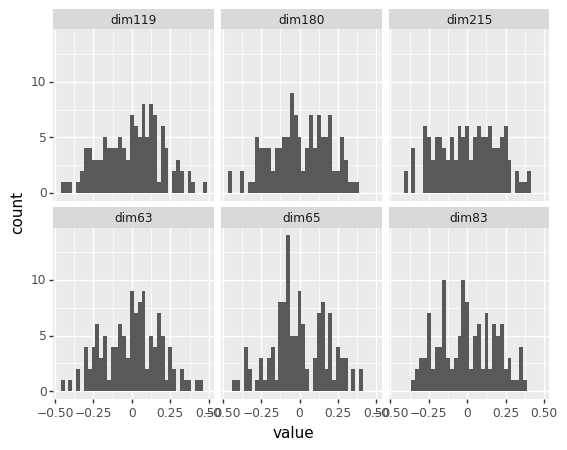

<ggplot: (708144894)>

In [132]:
col = 'dim119'
coset = 'index_of_2'

df = (
    rembed_df
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .filter(pl.col('variable').is_in(['dim215', 'dim119', 'dim83', 'dim65', 'dim180', 'dim63']))
)

ggplot(df, aes(x='value')) + geom_histogram(binwidth=0.025) + facet_wrap('~variable')

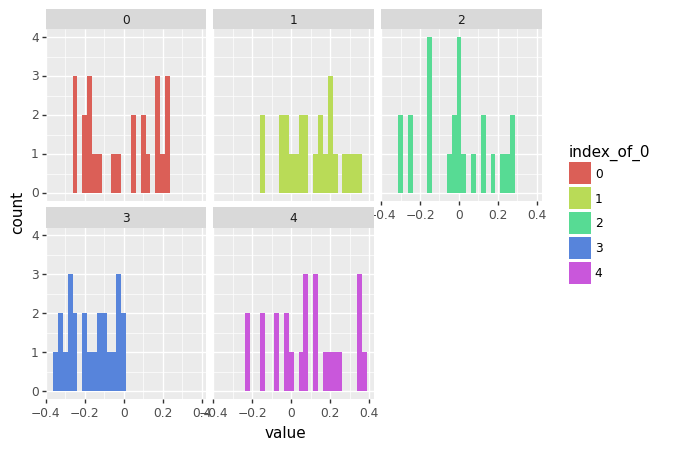

<ggplot: (702998913)>

In [139]:
col = 'dim83'
coset = 'index_of_0'

df = (
    rembed_df
    .filter(pl.col('irrep') == "(2, 1, 1, 1)")
    .filter(pl.col('variable') == col)
)

ggplot(df, aes(x='value', fill=coset)) + geom_histogram(binwidth=0.025) + facet_wrap(f'~{coset}')

In [327]:
from sklearn.decomposition import PCA


lembed = model.lembed.weight.detach().T.numpy()

pca = PCA()
components = pca.fit_transform(lembed)

In [329]:
components.shape

(256, 120)

In [330]:
pca_power_df, pca_ft = calc_power_contributions(torch.asarray(pca.components_).T, 5)

In [331]:
pca_power_df

irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,...,dim83,dim84,dim85,dim86,dim87,dim88,dim89,dim90,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(1, 1, 1, 1, 1...",6.6680e-7,0.000007,1.8658e-9,0.000001,0.000018,5.5306e-8,9.3018e-7,0.00001,0.000005,0.000324,0.000216,0.000303,0.000017,0.000958,0.001351,0.000311,0.000954,0.001191,0.003478,0.000004,0.000144,0.005086,0.003639,0.000235,0.000975,0.004151,0.000491,0.00363,0.000204,0.000576,0.009063,0.002206,0.00249,0.006312,0.023843,0.004963,...,0.002444,0.02198,0.002853,0.006575,0.019753,0.016043,0.010414,0.006892,0.01305,0.000765,8.1718e-7,0.000716,0.000103,0.000987,0.007716,0.009348,0.004325,0.004115,0.044153,0.001144,0.000627,0.001254,0.001039,0.001333,0.002586,0.000711,0.005527,0.00039,0.000262,0.00193,0.00024,0.001385,0.000006,0.000379,0.001491,0.000071,0.000379
"""(2, 1, 1, 1)""",0.999968,0.999985,0.999967,0.999978,0.99974,0.011772,0.988703,0.999813,0.999222,0.006957,0.008069,0.001491,0.00052,0.007194,0.001062,0.002064,0.005782,0.024782,0.95047,0.042343,0.015161,0.870673,0.183772,0.087409,0.103966,0.617871,0.210372,0.834025,0.048641,0.150394,0.006687,0.045059,0.125602,0.312343,0.077336,0.133274,...,0.032327,0.063392,0.017316,0.016536,0.031786,0.033999,0.006938,0.030372,0.020779,0.052409,0.010244,0.053588,0.027424,0.012052,0.004253,0.049893,0.020084,0.009549,0.009625,0.0236,0.012346,0.007675,0.015689,0.040625,0.005468,0.02268,0.011983,0.005522,0.003646,0.024295,0.018649,0.032356,0.010053,0.036619,0.016078,0.003773,0.003186
"""(2, 2, 1)""",0.000004,0.000001,0.000006,0.000009,0.000077,0.000007,0.0001,0.000097,0.000158,0.945455,0.964157,0.010312,0.017832,0.8393,0.038346,0.088269,0.121196,0.755451,0.013123,0.087147,0.022005,0.064182,0.653094,0.095865,0.741633,0.064936,0.069637,0.080548,0.808788,0.296318,0.115184,0.191632,0.23583,0.084229,0.153401,0.23661,...,0.086661,0.238848,0.14716,0.147065,0.160413,0.213489,0.223716,0.137208,0.122934,0.234104,0.281688,0.276745,0.150059,0.140222,0.174471,0.141657,0.144213,0.286154,0.168002,0.171747,0.169698,0.181235,0.109141,0.14936,0.170112,0.189398,0.163176,0.11103,0.156479,0.173455,0.280263,0.145342,0.183539,0.304365,0.231064,0.188971,0.138025
"""(3, 1, 1)""",0.000001,0.000002,0.000004,0.000003,0.000011,8.5629e-7,0.000014,0.000031,0.000095,0.005402,0.006473,0.00906,0.001728,0.013287,0.008185,0.005447,0.025339,0.01966,0.001135,0.023188,0.01072,0.009533,0.057248,0.046312,0.04651,0.028078,0.058973,0.035198,0.069846,0.169483,0.446176,0.22395,0.090173,0.274284,0.296708,0.386579,...,0.530604,0.362545,0.520392,0.453253,0.42976,0.341325,0.401298,0.300781,0.555568,0.353753,0.371607,0.451719,0.594326,0.429214,0.510368,0.433916,0.423466,0.481991,0.47649,0.590723,0.542358,0.435805,0.532951,0.523579,0.435983,0.449057,0.611052,0.51956,0.52261,0.50919,0.449301,0.615764,0.550719,0.369486,0.444956,0.469676,0.432937
"""(3, 2)""",0.000003,8.4992e-7,0.000004,0.000003,0.000018,0.000004,0.000011,0.000014,0.000033,0.035228,0.017261,0.019615,0.967589,0.035679,0.2841,0.692895,0.038136,0.074984,0.029094,0.767885,0.082426,0.039303,0.09217,0.737371,0.080404,0.273516,0.638934,0.033248,0.055262,0.35469,0.371576,0.231561,0.279907,0.240151,0.304388,0.179726,...,0.269022,0.189099,0.209509,0.236715,0.197924,0.321053,0.206756,0.296004,0.088716,0.237427,0.208316,0.177421,0.096362,0.161666,0.207675,0.091464,0.202439,0.153863,0.174034,0.113191,0.0714,0.178498,0.120123,0.171766,

In [332]:

pca_fb = sn_fourier_basis(pca_ft, S5)

pca_df = fourier_basis_to_df(pca_fb, 5)



In [333]:
pca_df = (
    pca_df
    #.melt(id_vars=['permutation', 'irrep'])
    .with_columns([
        pl.col('permutation').str.extract_all('([0-4])').alias('target_vals'),
    ])
    .with_columns([
        pl.col('target_vals').arr.get(0).alias('val_at_index_0'),
        pl.col('target_vals').arr.get(1).alias('val_at_index_1'),
        pl.col('target_vals').arr.get(2).alias('val_at_index_2'),
        pl.col('target_vals').arr.get(3).alias('val_at_index_3'),
        pl.col('target_vals').arr.get(4).alias('val_at_index_4'),
        get_index_of('target_vals', '0').alias('index_of_0'),
        get_index_of('target_vals', '1').alias('index_of_1'),
        get_index_of('target_vals', '2').alias('index_of_2'),
        get_index_of('target_vals', '3').alias('index_of_3'), 
        get_index_of('target_vals', '4').alias('index_of_4'),
        #pl.col(col).alias('activation')
    ])
)

In [334]:
pca_df.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,target_vals,val_at_index_0,val_at_index_1,val_at_index_2,val_at_index_3,val_at_index_4,index_of_0,index_of_1,index_of_2,index_of_3,index_of_4
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,list[str],str,str,str,str,str,str,str,str,str,str
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.000075,-0.000237,0.000004,-0.000109,0.000384,-0.000021,0.000088,0.000282,-0.000201,0.001643,-0.001343,-0.001589,0.000372,0.002825,0.003355,0.001611,-0.002819,-0.003151,0.005384,0.000172,0.001095,-0.00651,-0.005507,0.001399,0.00285,-0.005881,0.002022,-0.0055,0.001305,-0.00219,-0.00869,0.004288,-0.004555,0.007252,0.014096,...,0.002443,-0.000926,-0.002868,0.008019,0.008826,0.006004,-0.005856,-0.019182,0.003088,-0.002287,0.003232,-0.002943,0.003333,0.004642,0.002435,0.006787,0.001802,-0.001477,0.00401,-0.001415,0.003398,-0.000226,-0.001776,-0.003524,-0.000767,0.001778,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-0.041029,-0.002927,-0.161276,0.032714,0.019622,0.010981,0.084284,0.138106,-0.097007,0.008882,-0.008392,0.003801,-0.000678,0.008589,-0.002515,0.00379,0.017771,0.00875,0.112162,-0.007755,-0.008079,-0.100531,-0.028453,-0.043777,0.047413,0.108929,0.044213,0.009825,-0.000839,0.022226,0.004539,-0.01176,-0.03215,0.043784,-0.00357,...,-0.031604,0.00632,0.013759,0.002276,-0.03462,-0.009649,0.002843,0.005145,0.01341,-0.00048,0.010664,-0.004268,0.024628,0.00122,-0.019531,0.001598,0.007761,-0.002833,0.011376,0.000611,-0.025143,-0.00068,-0.014615,-0.011657,0.001019,-0.000389,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.000118,0.00005,0.000336,0.000032,0.000347,0.00011,0.000479,-0.000289,-0.000756,0.014347,-0.109187,0.01293,-0.020268,-0.115601,-0.028096,0.039116,-0.000246,0.049474,0.002115,-0.013467,0.003221,0.020622,0.104694,-0.003973,-0.040798,0.02893,0.025626,-0.005599,0.091143,-0.026963,-0.019468,-0.006965,0.034095,-0.022796,0.015805,...,-0.016268,0.026785,0.012978,0.041856,0.047235,0.015551,-0.030364,-0.046231,-0.03783,-0.027541,-0.025253,0.014383,0.017821,0.012282,0.015721,0.043061,-0.029311,0.003935,-0.030869,0.013706,0.013868,-0.00069,0.048928,-0.034489,0.031905,-0.022481,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.000187,0.000013,-0.000156,-0.000337,0.000372,-0.000105,-0.000213,0.000698,-0.00208,0.005479,-0.008567,-0.002153,-0.000825,-0.007421,-0.000261,0.00308,0.006976,-0.022269,0.003321,0.001968,0.007473,-0.024041,-0.060643,0.031525,0.032149,-0.016292,0.015754,-0.00753,0.062569,0.087446,-0.130451,-0.036655,0.014984,-0.081834,-0.039889,...,0.072691,-0.039685,-0.014192,0.002961,0.112719,0.008659,0.0129,-0.036477,0.056776,-0.145961,0.020697,0.036923,0.123777,-0.072576,0.031261,-0.020689,0.038351,0.033891,-0.140592,-0.071019,-0.172263,-0.100967,0.043848,-0.041296,-0.013506,0.107505,"[""0"", ""1"", ... ""4""]","""0""","""1""","""2""","""3""","""4""","""0""","""1""","""2""","""3""","""4"""
"""(0, 1, 2, 3, 4...","""(3, 2)""",-0.000186,-0.000169,-0.000127,-0.000039,-0.000045,0.000165,0.000047,0.000138,-0.000263,-0.001306,-0.007477,-0.018943,-0.076281,0.00902,0.000888,0.008235,-0.035059,-0.064749,0.04933,0.240073,-0.075195,-0.003499,0.018723,0.047948,-0

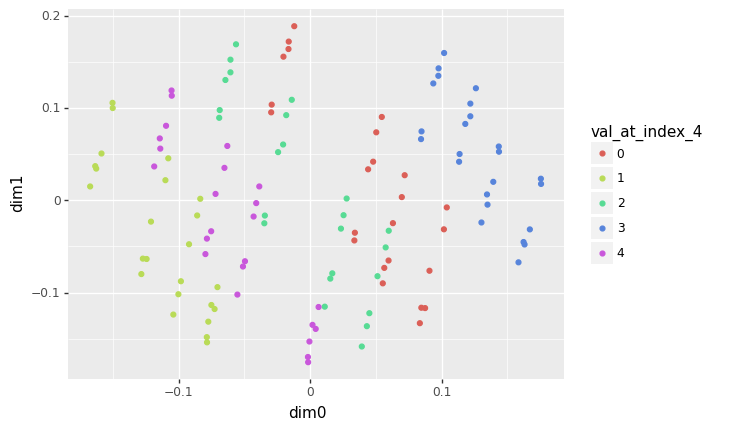

<ggplot: (708119625)>

In [363]:

coset = 'val_at_index_4'

ggplot(pca_df.filter(pl.col('irrep') == "(2, 1, 1, 1)"), aes(x = 'dim0', y='dim1', color=coset)) + geom_point()

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 6'. Pick better value with 'binwidth'.


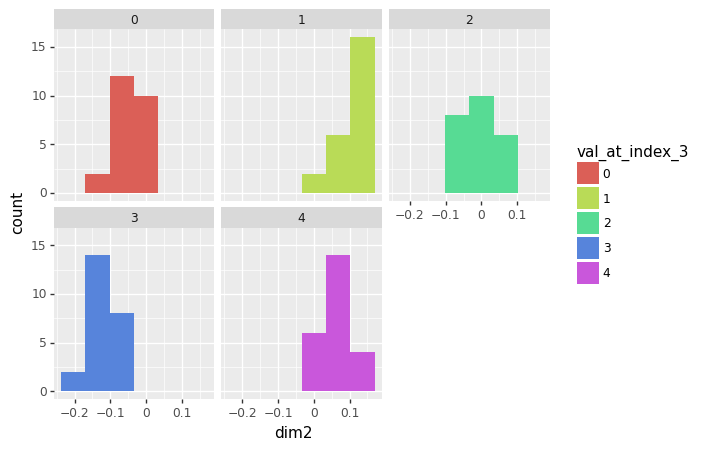

<ggplot: (709896114)>

In [348]:
coset = 'val_at_index_3'

ggplot(pca_df.filter(pl.col('irrep') == "(2, 1, 1, 1)"), aes(x = 'dim2', fill=coset)) + geom_histogram() + facet_wrap(f'~{coset}')

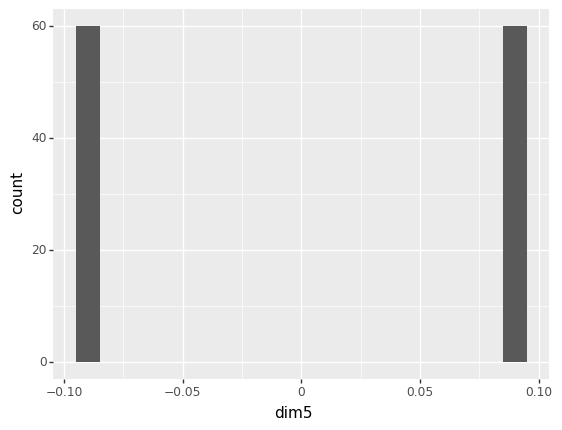

<ggplot: (714344295)>

In [326]:
ggplot(pca_df.filter(pl.col('irrep') == "(5,)"), aes(x = 'dim5')) + geom_histogram(binwidth=0.01)

In [365]:
S6 = Permutation.full_group(6)


triple_transpositions = [p for p in S6 if p.conjugacy_class == (2, 2, 2)]


In [378]:
"""
special_gen = [[(1, 0, 3, 2, 5, 4), (0, 5, 2, 1, 3, 4)],
        [(1, 0, 3, 2, 5, 4), (0, 5, 1, 3, 2, 4)],
        [(1, 0, 3, 2, 5, 4), (0, 5, 1, 2, 4, 3)],
        [(1, 0, 3, 2, 5, 4), (5, 1, 2, 0, 3, 4)],
        [(1, 0, 4, 5, 2, 3), (0, 5, 1, 3, 2, 4)],
        [(1, 0, 4, 5, 2, 3), (0, 5, 1, 2, 4, 3)]
              ]
              """
special_gen = [[(0, 2, 3, 4, 5, 1), (0, 2, 1, 3, 4, 5)], #1 fix 0
            [(2, 1, 3, 4, 5, 0), (2, 1, 0, 3, 4, 5)], #2 fix 1
            [(1, 3, 2, 4, 5, 0), (1, 0, 2, 3, 4, 5)], #3 fix 2
            [(1, 2, 4, 3, 5, 0), (1, 0, 2, 3, 4, 5)], #4 fix 3
            [(1, 2, 3, 0, 4, 5), (5, 1, 2, 3, 4, 0)], #5 fix 4
            [(1, 2, 3, 4, 0, 5), (1, 0, 2, 3, 4, 5)]]  #6 fix 5]

In [379]:
special_S5s = [generate_subgroup(gen) for gen in special_gen]

In [380]:
special0 = special_S5s[4]
special1 = tuple(sorted(special_S5s[1]))

my_shame = []

for g in S6:
    conjugated = sorted([(g.inverse * Permutation(perm) * g).sigma for perm in special0])
    if tuple(conjugated) == special1:
        my_shame.append(g)
len(my_shame)

120

In [381]:
my_shame

[(0, 2, 3, 5, 1, 4),
 (0, 2, 4, 3, 1, 5),
 (0, 2, 5, 4, 1, 3),
 (0, 3, 2, 4, 1, 5),
 (0, 3, 4, 5, 1, 2),
 (0, 3, 5, 2, 1, 4),
 (0, 4, 2, 5, 1, 3),
 (0, 4, 3, 2, 1, 5),
 (0, 4, 5, 3, 1, 2),
 (0, 5, 2, 3, 1, 4),
 (0, 5, 3, 4, 1, 2),
 (0, 5, 4, 2, 1, 3),
 (2, 0, 3, 4, 1, 5),
 (2, 0, 4, 5, 1, 3),
 (2, 0, 5, 3, 1, 4),
 (2, 3, 0, 5, 1, 4),
 (2, 3, 4, 0, 1, 5),
 (2, 3, 5, 4, 1, 0),
 (2, 4, 0, 3, 1, 5),
 (2, 4, 3, 5, 1, 0),
 (2, 4, 5, 0, 1, 3),
 (2, 5, 0, 4, 1, 3),
 (2, 5, 3, 0, 1, 4),
 (2, 5, 4, 3, 1, 0),
 (3, 0, 2, 5, 1, 4),
 (3, 0, 4, 2, 1, 5),
 (3, 0, 5, 4, 1, 2),
 (3, 2, 0, 4, 1, 5),
 (3, 2, 4, 5, 1, 0),
 (3, 2, 5, 0, 1, 4),
 (3, 4, 0, 5, 1, 2),
 (3, 4, 2, 0, 1, 5),
 (3, 4, 5, 2, 1, 0),
 (3, 5, 0, 2, 1, 4),
 (3, 5, 2, 4, 1, 0),
 (3, 5, 4, 0, 1, 2),
 (4, 0, 2, 3, 1, 5),
 (4, 0, 3, 5, 1, 2),
 (4, 0, 5, 2, 1, 3),
 (4, 2, 0, 5, 1, 3),
 (4, 2, 3, 0, 1, 5),
 (4, 2, 5, 3, 1, 0),
 (4, 3, 0, 2, 1, 5),
 (4, 3, 2, 5, 1, 0),
 (4, 3, 5, 0, 1, 2),
 (4, 5, 0, 3, 1, 2),
 (4, 5, 2, 0, 1, 3),
 (4, 5, 3, 2,